In [140]:
"""
Notebook to calculate analyse relationship between running and stimulus.
"""
import os

import numpy as np
import pickle
import h5py
import pandas
import scipy.stats
from matplotlib import pyplot as plt
%matplotlib inline  

import sync_util

In [89]:
# parent class to house general attributes and functions
class Stim(object):
    """Deals with the different stimuli that may appear on the screen during an experiment.
    """
    def __init__(self, exp, stim_n):
        self.exp = exp
        self._init_attribs(stim_n)
        
    def _init_attribs(self, stim_n):
        if self.stim_type == 'grayscr':
            self._get_stim_disps()
        else:
            self.stim_n = stim_n
            self.stim = self.exp.stim_dict['stimuli'][self.stim_n]
            self.blank_seg = exp.stim_dict['stimuli'][self.stim_n]['blank_sweeps']
            self._get_stim_disps()
            self._get_frames()
            self._get_running()
    
    def _get_stim_disps(self):
        """Get display sequences for each stimulus.
        Note: These display sequences take into account the pre and post blank periods. (So they are shifted.)
        """
        disps = []
        for i in range(self.exp.n_stims):
            # add pre-blank sec to all display seq
            disps.append(self.exp.stim_dict['stimuli'][i]['display_sequence']+self.exp.pre_blank) 
        if self.stim_type == 'gabors' or self.stim_type == 'bricks': 
            self.disp_seq = disps[self.stim_n] # stimulus display seq (in sec)
            self.block_len = np.diff(self.disp_seq) # length in sec of each display period
        elif self.stim_type == 'grayscr':
            # display seq times are calculated as periods before, after and between stimulus block
            stim_disps_2D = []
            for x in disps:
                stim_disps_2D.append(x[0])
            stim_disps_2D = np.asarray(stim_disps_2D)
            stim_disps_2D = stim_disps_2D[stim_disps_2D[:,1].argsort()] # sort from low to high start time
            self.disp_seq = []
            if stim_disps_2D[0][0] != 0: # checking if grayscr occurs before first stim
                self.disp_seq.append([0, stim_disps_2D[0][0]])
            for i in range(len(stim_disps_2D)-1):
                # add intervening grayscreen display times
                self.disp_seq.append([stim_disps_2D[i][1], stim_disps_2D[i+1][0]])
            if self.exp.post_blank != 0: # checking if grayscr occurs after last stim
                self.disp_seq.append([stim_disps_2D[i+1][0], stim_disps_2D[i+1][0]+self.exp.post_blank])
            self.block_len = np.diff(self.disp_seq)
        else:
            raise ValueError('Stimulus type \'{}\' not recognized.'.format(self.stim_type))
        self.n_blocks = len(self.disp_seq)
        
    def _get_frames(self):
        # fill out the frame_list to be the same length as running array
        self.frame_list = int(self.exp.pre_blank*self.exp.stim_fps)*[-1] + self.stim['frame_list'].tolist() + \
                          int((self.exp.tot_frames - len(self.stim['frame_list']) + \
                          self.exp.post_blank)*self.exp.stim_fps)*[-1] 
        self.seg_range = [] # range of segments in each block
        self.frame_n = [] # frame numbers for each block
        self.n_frames = [] # number of frames in each block
        min_seg = 0
        up_lim = 0
        for i in range(self.n_blocks):
            # get segment ranges
            up_lim += int(np.diff(self.disp_seq[i])/self.seg_len_s)
            max_seg = np.max(exp.stim_dict['stimuli'][self.stim_n]['sweep_order'][:up_lim]) # max segment
            self.seg_range.append([min_seg, max_seg])
            # get frame ranges
            min_ind = self.frame_list.index(min_seg)    
            max_ind = len(self.frame_list)-1 - self.frame_list[::-1].index(max_seg)
            self.frame_n.append([min_ind, max_ind])
            # get number of frames in block
            length = max_ind-min_ind+1
            exp_length = self.block_len[i][0]*self.exp.stim_fps
            self.n_frames.extend([length])
            min_seg = max_seg + 1
    
    def _get_running(self):
        """
        """
        self.run = []
        for i in range(self.n_blocks):
            self.run.extend([self.exp.run_array[self.frame_n[i][0]:self.frame_n[i][1]]])
    
    
class Gabors(Stim):
    """Inherits from Stim class.
    Deals with information related to sequences where the gabors are being displayed, including the 300 ms segments
    where the screen is gray.
    """
    def __init__(self, exp, stim_n):
        self.stim_type = 'gabors'
        self.seg_ps = 1/1.5*4 # 4 gabor segments (and 1 blank segment) per 1.5s
        self.seg_len_s = 0.3 # in sec
        self.surp_min_s = 3
        self.surp_max_s = 6
        self.reg_min_s = 30
        self.reg_max_s = 90
        self.pre = 1*self.seg_len_s # 300 ms blank
        self.post = 4*self.seg_len_s # 1200 ms gabors
        
        Stim.__init__(self, exp, stim_n)
        self._get_A_frames()
        self._get_surp_frames()
    
    def _get_A_frames(self):
        seg_ind = self.exp.align_df.loc[(exp.align_df['stimType'] == 1) & (exp.align_df['GABORFRAME'] == 0)]['stimSeg'].tolist()
        self.A_frame_n = []
        for i in seg_ind:
            self.A_frame_n.extend([self.frame_list.index(i)])
    
    def _get_surp_frames(self):
        seg_ind_all_surp = self.exp.align_df.loc[(exp.align_df['stimType'] == 1) & (exp.align_df['surp'] == 1)]['stimSeg'].tolist()
        seg_ind_all_nosurp = self.exp.align_df.loc[(exp.align_df['stimType'] == 1) & (exp.align_df['surp'] == 0)]['stimSeg'].tolist()
        self.surp_frame_n = []
        self.first_surp_frame_n = []
        self.nosurp_frame_n = []
        self.first_nosurp_frame_n = []
        for i, j in enumerate(seg_ind_all_surp):
            self.surp_frame_n.extend([self.frame_list.index(j)])
            # get only non-consecutive seg to get only first surprise
            if i == 0 or j != seg_ind_all_surp[i-1]+1:
                self.first_surp_frame_n.extend([self.frame_list.index(j)])
        for i, j in enumerate(seg_ind_all_nosurp):
            self.nosurp_frame_n.extend([self.frame_list.index(j)])
            if i == 0 or j != seg_ind_all_nosurp[i-1]+1:
                self.first_nosurp_frame_n.extend([self.frame_list.index(j)])
    
class Bricks(Stim):
    """Inherits from Stim class.
    Deals with information related to sequences where the bricks are being displayed.
    """
    def __init__(self, exp, stim_n):
        self.stim_type = 'bricks'
        self.seg_ps = 1 # 1 segment per second
        self.seg_len_s = 1 # 1 segment is 1 second
        self.surp_min_s = 2
        self.surp_max_s = 4
        self.reg_min_s = 30
        self.reg_max_s = 90
        
        Stim.__init__(self, exp, stim_n)
        self._get_surp_frames()
        self._get_dir_frames()
        

    def _get_dir_frames(self):
        # does not include surprise frames
        for i in ['left', 'right']:
            seg_ind = self.exp.align_df.loc[(exp.align_df['stimType'] == 0) & (exp.align_df['surp'] == 0) &
                                           (exp.align_df['stimPar2'] == i)]['stimSeg'].tolist()
            frame_n = []
            for j in seg_ind:
                frame_n.extend([self.frame_list.index(j)])
            if i == 'left':
                self.left_frame_n = frame_n[:]
            elif i == 'right':
                self.right_frame_n = frame_n[:]
    
    def _get_surp_frames(self):
        seg_ind_all_surp = self.exp.align_df.loc[(exp.align_df['stimType'] == 0) & (exp.align_df['surp'] == 1)]['stimSeg'].tolist()
        seg_ind_all_nosurp = self.exp.align_df.loc[(exp.align_df['stimType'] == 0) & (exp.align_df['surp'] == 0)]['stimSeg'].tolist()
        self.surp_frame_n = []
        self.first_surp_frame_n = []
        self.nosurp_frame_n = []
        self.first_nosurp_frame_n = []
        for i, j in enumerate(seg_ind_all_surp):
            self.surp_frame_n.extend([self.frame_list.index(j)])
            # get only non-consecutive seg to get only first surprise
            if i == 0 or j != seg_ind_all_surp[i-1]+1:
                self.first_surp_frame_n.extend([self.frame_list.index(j)])
        for i, j in enumerate(seg_ind_all_nosurp):
            self.nosurp_frame_n.extend([self.frame_list.index(j)])
            if i == 0 or j != seg_ind_all_nosurp[i-1]+1:
                self.first_nosurp_frame_n.extend([self.frame_list.index(j)])
        

class Grayscr(Stim):
    """Inherits from Stim class.
    Deals with information related to sequences where the screen is gray.
    """
    
    def __init__(self, exp):
        self.stim_type = 'grayscr'
        
        Stim.__init__(self, exp, None)
        self.min_s = 60 # hard coding a minimum secto allow short grayscr to be excluded
        self._get_frames()
        self._get_running()
        
    def _get_frames(self):
        all_stim_frames = []
        for i in range(self.exp.n_stims): 
            stim_frames = self.exp.stim_dict['stimuli'][i]['frame_list'].tolist()
            stim_frames = int(self.exp.pre_blank*self.exp.stim_fps)*[-1] + stim_frames + int((self.exp.tot_frames - \
                          len(stim_frames) + self.exp.post_blank*self.exp.stim_fps))*[-1]   
            all_stim_frames.append(np.asarray(stim_frames))
        all_stim_frames = np.asarray(all_stim_frames)
        all_frames_sum = np.sum(all_stim_frames, axis=0, dtype=int)
        
        # get the start-end of grayscr
        pos = 0
        self.frame_n_all = []
        self.n_frames_all = []
        self.frame_n_excl = []
        self.n_frames_excl = []
        for i in range(len(all_frames_sum)):
            if pos == 0 and all_frames_sum[i] == -1*self.exp.n_stims:
                start = i
                pos = 1
            elif pos == 1 and all_frames_sum[i] != -1*self.exp.n_stims:
                pos = 0
                self.frame_n_all.append([start, i])
                self.n_frames_all.extend([i-start])
                if (i-start) > self.min_s:
                    self.frame_n_excl.append([start, i])
                    self.n_frames_excl.extend([i-start])
        if pos == 0:
            self.frame_n_all.append([start, i+1])
            self.n_frames_all.extend([i+1-start])
            if (i+1-start) > self.min_s:
                    self.frame_n_excl.append([start, i+1])
                    self.n_frames_excl.extend([i+1-start])
    
    def _get_running(self):
        self.run_all = [] # includes segments within stimuli (e.g., gabors)
        self.run_excl = []
        for i in range(len(self.frame_n_all)):
            self.run_all.extend([self.exp.run_array[self.frame_n_all[i][0]:self.frame_n_all[i][1]]])
            if (self.n_frames_all[i]) > self.min_s:
                self.run_excl.extend([self.exp.run_array[self.frame_n_all[i][0]:self.frame_n_all[i][1]]])

In [7]:
class Experiment(object):
    """
    Experiment object contains information relevant to an experiment, particularly needed
    analyse running and stimulus. Two-photon component not implemented currently implemented.
    """
    def __init__(self, filename):
        self.filename = filename
        self._init_filenames()
        
    def _init_filenames(self):
        """
        Creates file name attributes for the stimulus dictionary pickle, h5 sync and 
        stimulus alignment dataframe pickle from the filename attribute
        """
        # file names
        self.stim_pkl_name = self.filename + '_stim.pkl'
        self.sync_h5_name = self.filename + '_sync.h5'
        self.align_pkl_name = self.filename + '_df.pkl'
    
    # load stim dictionary as an attribute (and any other general stim info, like fps)
    def load_stim_dict(self):
        with open(self.stim_pkl_name, 'rb') as f:
            self.stim_dict = pickle.load(f)
        self.stim_fps = self.stim_dict['fps']
        self.tot_frames = self.stim_dict['total_frames']
        self.pre_blank = self.stim_dict['pre_blank_sec'] # seconds
        self.post_blank = self.stim_dict['post_blank_sec'] # seconds
        self.drop_frames = self.stim_dict['droppedframes']
        self.n_drop_frames = len(self.drop_frames[0])
        if np.float(self.n_drop_frames)/self.tot_frames > 0.0003:
            print('WARNING: {} dropped stimulus frames out of {}.'.format(self.n_drop_frames, self.tot_frames))
        
    def load_sync_h5(self):
        raise NotImplementedError('Loading h5 sync file of an experiment has not been implemented yet.')
    
    # load alignment pickle as an attribute
    def load_align_df(self):
        # create align_df if doesn't exist
        if not os.path.exists(self.align_pkl_name):
            stimulus_alignment = sync_util.get_stim_frames(self.stim_pkl_name, self.sync_h5_name, self.align_pkl_name)
        else:
            print('stimulus alignment pickle already exists.')

        with open(self.align_pkl_name, 'rb') as f:
            self.align_df = pandas.read_pickle(f)       
    
    # load running speed array as an attribute
    def load_run(self):
        # running speed per stimulus frame in cm/s
        self.run_array = sync_util.get_run_speed(self.stim_pkl_name)
    
    # load additional info as attributes
    def extract_stim_run_info(self): 
        if not hasattr(self, 'stim_dict'):
            self.load_stim_dict()
        if not hasattr(self, 'align_df'):
            self.load_align_df()
        if not hasattr(self, 'run_array'):
            self.load_run()
        
        self.stim_types = []
        self.n_stims = len(self.stim_dict['stimuli'])
        self.stims = []
        for i in range(self.n_stims):
            stim = self.stim_dict['stimuli'][i]
            stim_type = stim['stimParams']['elemParams']['name']
            self.stim_types.extend([stim_type])   
            if stim_type == 'gabors':
                self.gabors = Gabors(self, i)
            elif stim_type == 'bricks':
                self.bricks = Bricks(self, i)
        self.grayscr = Grayscr(self)
        
        

In [9]:
# session to run
file_name = 'data/ophys_session_719034388/719034388_389886_20180712'

In [90]:
exp = Experiment(file_name) # can be long, particularly if running stimulus alignment

exp.extract_stim_run_info() # extracts info required to analyse stim-run

stimulus alignment pickle already exists.


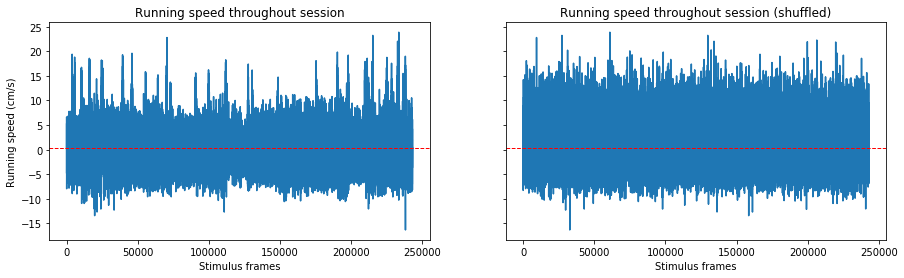

In [107]:
# plot running across all blocks
fig1a, ax1a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax1a[0].plot(exp.run_array)
ax1a[0].set_title('Running speed throughout session')
ax1a[0].set_ylabel('Running speed (cm/s)')
ax1a[0].set_xlabel('Stimulus frames')
ax1a[0].axhline(y=np.mean(exp.run_array), ls='dashed', c='r', lw='1')

temp_rand = exp.run_array.copy()
np.random.shuffle(temp_rand)
ax1a[1].plot(temp_rand)
ax1a[1].set_title('Running speed throughout session (shuffled)')
ax1a[1].set_xlabel('Stimulus frames')
ax1a[1].axhline(y=np.mean(temp_rand), ls='dashed', c='r', lw='1')

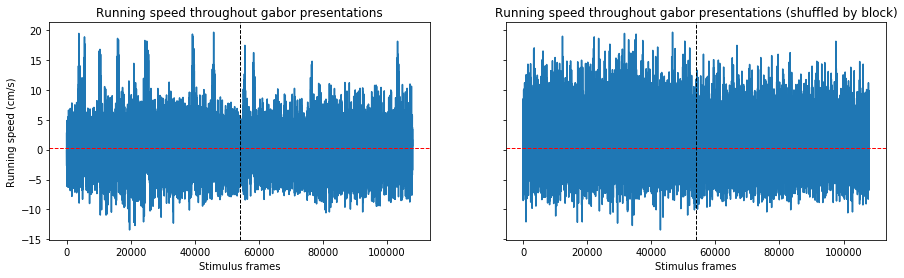

In [106]:
# plot running across gabor blocks
gab_run_rand = []
gab_run_breaks = []
temp_br = 0
for i in range(len(exp.gabors.run)):
    temp = exp.gabors.run[i].copy()
    np.random.shuffle(temp)
    gab_run_rand.extend([temp])
    # keep track of block breaks
    temp_br += exp.gabors.run[i].shape[0]
    gab_run_breaks.extend([temp_br])

# unite
gab_run_all = np.concatenate(exp.gabors.run)
gab_run_rand_all = np.concatenate(gab_run_rand)

# plot
fig2a, ax2a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax2a[0].plot(gab_run_all)
ax2a[0].set_title('Running speed throughout gabor presentations')
ax2a[0].set_ylabel('Running speed (cm/s)')
ax2a[0].set_xlabel('Stimulus frames')
ax2a[0].axhline(y=np.mean(gab_run_all), ls='dashed', c='r', lw='1')
for i in range(len(gab_run_breaks)-1):
    ax2a[0].axvline(x=gab_run_breaks[i], ls='dashed', c='k', lw='1')

ax2a[1].plot(gab_run_rand_all)
ax2a[1].set_title('Running speed throughout gabor presentations (shuffled by block)')
ax2a[1].set_xlabel('Stimulus frames')
ax2a[1].axhline(y=np.mean(gab_run_rand_all), ls='dashed', c='r', lw='1')
for i in range(len(gab_run_breaks)-1):
    ax2a[1].axvline(x=gab_run_breaks[i], ls='dashed', c='k', lw='1')

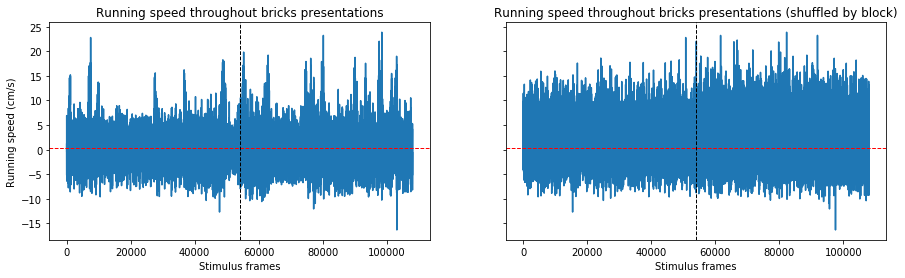

In [105]:
# plot running across brick blocks
bri_run_rand = []
bri_run_breaks = []
temp_br = 0
for i in range(len(exp.bricks.run)):
    temp = exp.bricks.run[i].copy()
    np.random.shuffle(temp)
    bri_run_rand.extend([temp])
    # keep track of block breaks
    temp_br += exp.bricks.run[i].shape[0]
    bri_run_breaks.extend([temp_br])

# unite
bri_run_all = np.concatenate(exp.bricks.run)
bri_run_rand_all = np.concatenate(bri_run_rand)

# plot
fig2c, ax2c = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax2c[0].plot(bri_run_all)
ax2c[0].set_title('Running speed throughout bricks presentations')
ax2c[0].set_ylabel('Running speed (cm/s)')
ax2c[0].set_xlabel('Stimulus frames')
ax2c[0].axhline(y=np.mean(bri_run_all), ls='dashed', c='r', lw='1')
for i in range(len(bri_run_breaks)-1):
    ax2c[0].axvline(x=bri_run_breaks[i], ls='dashed', c='k', lw='1')

ax2c[1].plot(bri_run_rand_all)
ax2c[1].set_title('Running speed throughout bricks presentations (shuffled by block)')
ax2c[1].set_xlabel('Stimulus frames')
ax2c[1].axhline(y=np.mean(bri_run_rand_all), ls='dashed', c='r', lw='1')
for i in range(len(bri_run_breaks)-1):
    ax2c[1].axvline(x=bri_run_breaks[i], ls='dashed', c='k', lw='1')

In [108]:
# plot average running for each 1.5 s subblock (ABCD/E): 300 ms before 0 to 1200 ms after
ran = [-exp.gabors.pre, exp.gabors.post]
pre = int(exp.stim_fps * ran[0]) # number of frames before
post = int(exp.stim_fps * ran[1]) # number of frames after
length = int((np.abs(pre) + np.abs(post))) # nbr of frames

x_ran_av = np.linspace(ran[0], ran[1], length) 

# get corresponding running subblocks and stats
gab_pre = [x + pre for x in exp.gabors.A_frame_n]
gab_post = [x + post for x in exp.gabors.A_frame_n]
gab_ind = zip(gab_pre, gab_post)

# get running values (use general run array, as A_frame_n are for full array)   
temp = [exp.run_array[x[0]:x[1]] for x in gab_ind]
# create a shuffled version (need to do both axes separately)
temp2 = np.asarray(temp[:])
np.random.shuffle(temp2)
np.random.shuffle(temp2.T)
temp2 = temp2.tolist()

gab_run_subbl = np.empty([len(temp), len(temp[0])])
gab_run_subbl_rand = np.empty_like(gab_run_subbl)
for i in range(len(temp)):
    if len(temp[i]) == len(temp[0]):
        gab_run_subbl[i] = np.asarray(temp[i])
        gab_run_subbl_rand[i] = np.asarray(temp2[i])
    # truncate the array in this case
    else:
        gab_run_subbl = gab_run_subbl[:i]
        gab_run_subbl_rand = gab_run_subbl_rand[:i]

# gather stats
gab_run_subbl_av = np.mean(gab_run_subbl, axis=0)
gab_run_subbl_rand_av = np.mean(gab_run_subbl_rand, axis=0)
gab_run_subbl_std = np.std(gab_run_subbl, axis=0)
gab_run_subbl_rand_std = np.std(gab_run_subbl_rand, axis=0)

Text(0.5,0,'Time (s)')

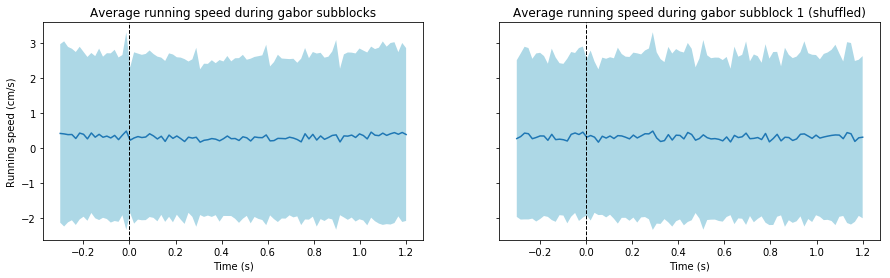

In [109]:
# plot
fig3a, ax3a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax3a[0].plot(x_ran_av, gab_run_subbl_av)
ax3a[0].fill_between(x_ran_av,  gab_run_subbl_av - gab_run_subbl_std,  gab_run_subbl_av + gab_run_subbl_std, facecolor='lightblue')
ax3a[0].axvline(x=0, ls='dashed', c='k', lw='1')
ax3a[0].set_title('Average running speed during gabor subblocks')
ax3a[0].set_ylabel('Running speed (cm/s)')
ax3a[0].set_xlabel('Time (s)')

ax3a[1].plot(x_ran_av, gab_run_subbl_rand_av)
ax3a[1].fill_between(x_ran_av,  gab_run_subbl_rand_av - gab_run_subbl_rand_std,  gab_run_subbl_rand_av + gab_run_subbl_rand_std, 
                  facecolor='lightblue')
ax3a[1].axvline(x=0, ls='dashed', c='k', lw='1')
ax3a[1].set_title('Average running speed during gabor subblock 1 (shuffled)')
ax3a[1].set_xlabel('Time (s)')

In [110]:
# get autocorrelation, snips around desired lag
lag_s = 3 # in sec
lag_f = int(exp.stim_fps * lag_s)

gab_autocorr_snips = []
gab_autocorr_rand_snips = []
for i in range(exp.gabors.n_blocks):
       
    # remove the mean of the values
    norm_values = exp.gabors.run[i] - np.mean(exp.gabors.run[i])
    # get autocorrelation snip
    autocorr = np.correlate(norm_values, norm_values, 'full')
    
    mid = int((autocorr.shape[0]-1)/2) # autocorr will always produce an odd length, so this should always give an integer
    autocorr_snip = autocorr[mid-lag_f:mid+lag_f]
    
    # deep copy normalized values and randomize
    norm_rand_values = norm_values[:]
    np.random.shuffle(norm_rand_values)
    autocorr_snip_rand = np.correlate(norm_rand_values, norm_rand_values, 'full')[mid-lag_f:mid+lag_f]
    
    # record normalized, snipped autocorrelations
    gab_autocorr_snips.append((autocorr_snip/np.max(autocorr_snip)).tolist())
    gab_autocorr_rand_snips.append((autocorr_snip_rand/np.max(autocorr_snip_rand)).tolist())

# average autocorrelations for each lag across blocks
gab_autocorr_mean = [float(sum(col))/len(col) for col in zip(*gab_autocorr_snips)]
gab_autocorr_rand_mean = [float(sum(col))/len(col) for col in zip(*gab_autocorr_rand_snips)]
    
x_auto_ran = np.linspace(-lag_s, lag_s, 2*lag_f)

Text(0.5,1,'Autocorrelation from -3 to 3 sec for gabors')

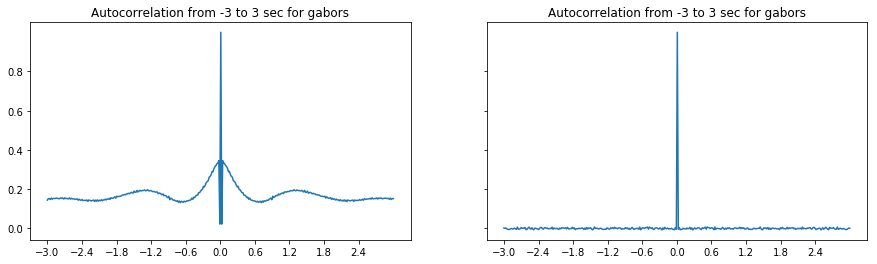

In [111]:
fig4a, ax4a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax4a[0].plot(x_auto_ran, gab_autocorr_mean)
ax4a[0].set_xticks(np.arange(-lag_s, lag_s, 0.6))
ax4a[0].set_yticks(np.arange(0, 1, 0.2))
ax4a[0].set_title('Autocorrelation from -3 to 3 sec for gabors')

ax4a[1].plot(x_auto_ran, gab_autocorr_rand_mean)
ax4a[1].set_xticks(np.arange(-lag_s, lag_s, 0.6))
ax4a[1].set_yticks(np.arange(0, 1, 0.2))
ax4a[1].set_title('Autocorrelation from -3 to 3 sec for gabors')

In [112]:
# Average running speed during 2-3 sec incl and following surprise vs no surprise

# gabors
ran = [-exp.gabors.surp_min_s, exp.gabors.surp_min_s+3] # adding extra time after
pre = int(exp.stim_fps * ran[0]) # number of frames before
post = int(exp.stim_fps * ran[1]) # number of frames after
length = int((np.abs(pre) + np.abs(post))) # nbr of frames

gab_x_ran_av = np.linspace(ran[0], ran[1], length) 

# get corresponding running subblocks and stats
gab_pre_surp = [x + pre for x in exp.gabors.first_surp_frame_n]
gab_post_surp = [x + post for x in exp.gabors.first_surp_frame_n]
gab_ind_surp = zip(gab_pre_surp, gab_post_surp)

gab_pre_nosurp = [x + pre for x in exp.gabors.first_nosurp_frame_n[1:]] #excluding first occurrence
gab_post_nosurp = [x + post for x in exp.gabors.first_nosurp_frame_n[1:]]
gab_ind_nosurp = zip(gab_pre_nosurp, gab_post_nosurp)

# get running values (use general run array, as A_frame_n are for full array)   
temp_surp = [exp.run_array[x[0]:x[1]] for x in gab_ind_surp]
temp_nosurp =  [exp.run_array[x[0]:x[1]] for x in gab_ind_nosurp]

gab_run_subbl_surp = np.empty([len(temp_surp), len(temp_surp[0])])
gab_run_subbl_nosurp = np.empty([len(temp_nosurp), len(temp_nosurp[0])])
for i in range(len(temp_surp)):
    if len(temp_surp[i]) == len(temp_surp[0]):
        gab_run_subbl_surp[i] = np.asarray(temp_surp[i])
    # truncate the array in this case
    else:
        gab_run_subbl_surp = gab_run_subbl_surp[:i]
        
for i in range(len(temp_nosurp)):
    if len(temp_nosurp[i]) == len(temp_nosurp[0]):
        gab_run_subbl_nosurp[i] = np.asarray(temp_nosurp[i])
    # truncate the array in this case
    else:
        gab_run_subbl_nosurp = gab_run_subbl_nosurp[:i]

# gather stats
gab_run_subbl_surp_av = np.mean(gab_run_subbl_surp, axis=0)
gab_run_subbl_nosurp_av = np.mean(gab_run_subbl_nosurp, axis=0)
gab_run_subbl_surp_std = np.std(gab_run_subbl_surp, axis=0)
gab_run_subbl_nosurp_std = np.std(gab_run_subbl_nosurp, axis=0)


# bricks
ran = [-exp.bricks.surp_min_s, exp.bricks.surp_min_s+3]
pre = int(exp.stim_fps * ran[0]) # number of frames before
post = int(exp.stim_fps * ran[1]) # number of frames after
length = int((np.abs(pre) + np.abs(post))) # nbr of frames

bri_x_ran_av = np.linspace(ran[0], ran[1], length) 

# get corresponding running subblocks and stats
bri_pre_surp = [x + pre for x in exp.bricks.first_surp_frame_n]
bri_post_surp = [x + post for x in exp.bricks.first_surp_frame_n]
bri_ind_surp = zip(bri_pre_surp, bri_post_surp)

bri_pre_nosurp = [x + pre for x in exp.bricks.first_nosurp_frame_n[1:]]
bri_post_nosurp = [x + post for x in exp.bricks.first_nosurp_frame_n[1:]]
bri_ind_nosurp = zip(bri_pre_nosurp, bri_post_nosurp)

# get running values (use general run array, as A_frame_n are for full array)   
temp_surp = [exp.run_array[x[0]:x[1]] for x in bri_ind_surp]
temp_nosurp =  [exp.run_array[x[0]:x[1]] for x in bri_ind_nosurp]

bri_run_subbl_surp = np.empty([len(temp_surp), len(temp_surp[0])])
bri_run_subbl_nosurp = np.empty([len(temp_nosurp), len(temp_nosurp[0])])
for i in range(len(temp_surp)):
    if len(temp_surp[i]) == len(temp_surp[0]):
        bri_run_subbl_surp[i] = np.asarray(temp_surp[i])
    # truncate the array in this case
    else:
        bri_run_subbl_surp = bri_run_subbl_surp[:i]
        
for i in range(len(temp_nosurp)):
    if len(temp_nosurp[i]) == len(temp_nosurp[0]):
        bri_run_subbl_nosurp[i] = np.asarray(temp_nosurp[i])
    # truncate the array in this case
    else:
        bri_run_subbl_nosurp = bri_run_subbl_nosurp[:i]

# gather stats
bri_run_subbl_surp_av = np.mean(bri_run_subbl_surp, axis=0)
bri_run_subbl_nosurp_av = np.mean(bri_run_subbl_nosurp, axis=0)
bri_run_subbl_surp_std = np.std(bri_run_subbl_surp, axis=0)
bri_run_subbl_nosurp_std = np.std(bri_run_subbl_nosurp, axis=0)

Text(0.5,0,'Time (s)')

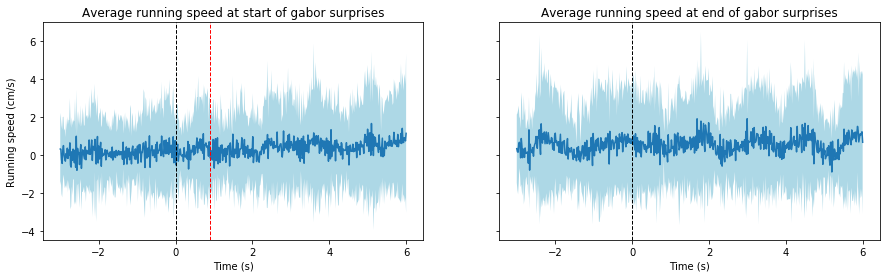

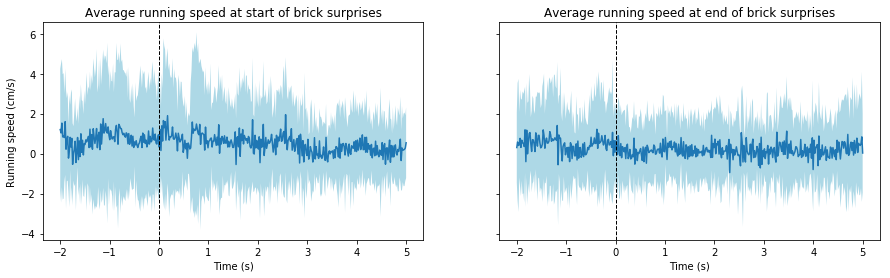

In [113]:
# plot
fig5a, ax5a = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax5a[0].plot(gab_x_ran_av, gab_run_subbl_surp_av)
ax5a[0].fill_between(gab_x_ran_av, gab_run_subbl_surp_av - gab_run_subbl_surp_std,  gab_run_subbl_surp_av + gab_run_subbl_surp_std, facecolor='lightblue')
ax5a[0].axvline(x=0, ls='dashed', c='k', lw='1')
ax5a[0].axvline(x=0.9, ls='dashed', c='r', lw='1')
ax5a[0].set_title('Average running speed at start of gabor surprises')
ax5a[0].set_ylabel('Running speed (cm/s)')
ax5a[0].set_xlabel('Time (s)')

ax5a[1].plot(gab_x_ran_av, gab_run_subbl_nosurp_av)
ax5a[1].fill_between(gab_x_ran_av, gab_run_subbl_nosurp_av - gab_run_subbl_nosurp_std,  gab_run_subbl_nosurp_av + gab_run_subbl_nosurp_std, facecolor='lightblue')
ax5a[1].axvline(x=0, ls='dashed', c='k', lw='1')
ax5a[1].set_title('Average running speed at end of gabor surprises')
ax5a[1].set_xlabel('Time (s)')

fig5c, ax5c = plt.subplots(ncols=2, sharey=True, figsize=(15, 4))
ax5c[0].plot(bri_x_ran_av, bri_run_subbl_surp_av)
ax5c[0].fill_between(bri_x_ran_av, bri_run_subbl_surp_av - bri_run_subbl_surp_std,  bri_run_subbl_surp_av + bri_run_subbl_surp_std, facecolor='lightblue')
ax5c[0].axvline(x=0, ls='dashed', c='k', lw='1')
ax5c[0].set_title('Average running speed at start of brick surprises')
ax5c[0].set_ylabel('Running speed (cm/s)')
ax5c[0].set_xlabel('Time (s)')

ax5c[1].plot(bri_x_ran_av, bri_run_subbl_nosurp_av)
ax5c[1].fill_between(bri_x_ran_av, bri_run_subbl_nosurp_av - bri_run_subbl_nosurp_std,  bri_run_subbl_nosurp_av + bri_run_subbl_nosurp_std, facecolor='lightblue')
ax5c[1].axvline(x=0, ls='dashed', c='k', lw='1')
ax5c[1].set_title('Average running speed at end of brick surprises')
ax5c[1].set_xlabel('Time (s)')

Text(0.5,1,'Statistics of running speed during bricks no surprise vs surprise')

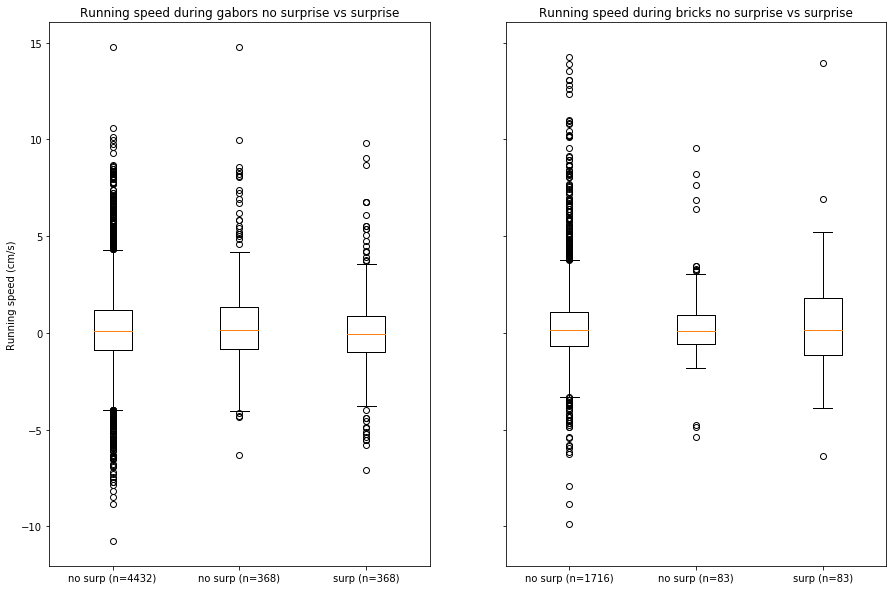

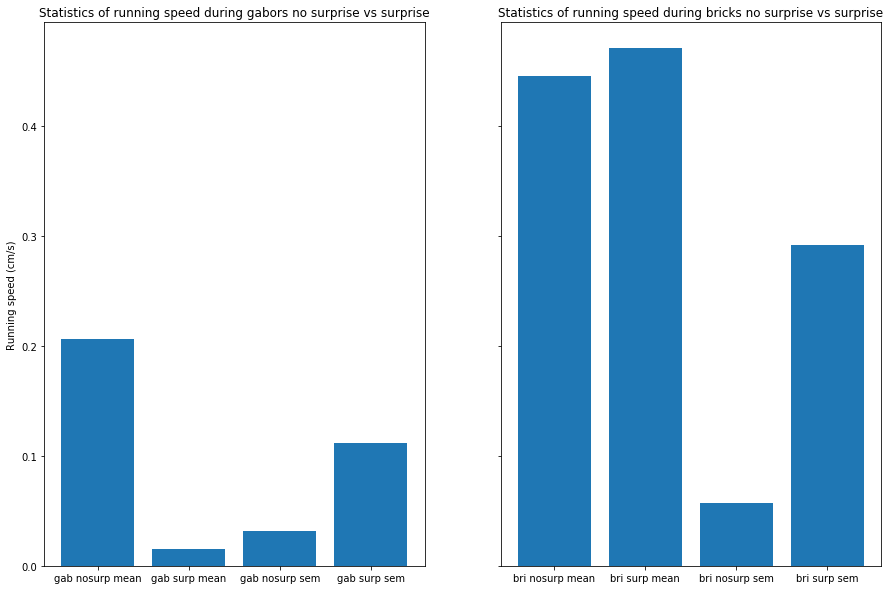

In [148]:
# Boxplot of surprise vs no surprise (bricks, gabors)
gab_nosurp_n = len(exp.gabors.nosurp_frame_n)
gab_surp_n = len(exp.gabors.surp_frame_n)
# get a random subset to plot
gab_nosurp_rand = exp.run_array[exp.gabors.nosurp_frame_n][:]

fig6, ax6 = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
ax6[0].boxplot([exp.run_array[exp.gabors.nosurp_frame_n], gab_nosurp_rand[:gab_surp_n], exp.run_array[exp.gabors.surp_frame_n]])
ax6[0].set_title('Running speed during gabors no surprise vs surprise')
ax6[0].set_ylabel('Running speed (cm/s)')
ax6[0].set_xticklabels(['no surp (n={})'.format(gab_nosurp_n), 'no surp (n={})'.format(gab_surp_n), 'surp (n={})'.format(gab_surp_n)])

bri_nosurp_n = len(exp.bricks.nosurp_frame_n)
bri_surp_n = len(exp.bricks.surp_frame_n)
# get a random subset to plot
bri_nosurp_rand = exp.run_array[exp.bricks.nosurp_frame_n][:]
ax6[1].boxplot([exp.run_array[exp.bricks.nosurp_frame_n], bri_nosurp_rand[:bri_surp_n], exp.run_array[exp.bricks.surp_frame_n]])
ax6[1].set_title('Running speed during bricks no surprise vs surprise')
ax6[1].set_xticklabels(['no surp (n={})'.format(bri_nosurp_n), 'no surp (n={})'.format(bri_surp_n), 'surp (n={})'.format(bri_surp_n)])

# bar plots of statistics
fig7, ax7 = plt.subplots(ncols=2, sharey=True, figsize=(15, 10))
ax7[0].bar(['gab nosurp mean', 'gab surp mean', 'gab nosurp sem', 'gab surp sem'], [np.mean(exp.run_array[exp.gabors.nosurp_frame_n]), np.mean(exp.run_array[exp.gabors.surp_frame_n]),
            scipy.stats.sem(exp.run_array[exp.gabors.nosurp_frame_n]), scipy.stats.sem(exp.run_array[exp.gabors.surp_frame_n])])
ax7[0].set_title('Statistics of running speed during gabors no surprise vs surprise')
ax7[0].set_ylabel('Running speed (cm/s)')

ax7[1].bar(['bri nosurp mean', 'bri surp mean', 'bri nosurp sem', 'bri surp sem'], [np.mean(exp.run_array[exp.bricks.nosurp_frame_n]), np.mean(exp.run_array[exp.bricks.surp_frame_n]),
            scipy.stats.sem(exp.run_array[exp.bricks.nosurp_frame_n]), scipy.stats.sem(exp.run_array[exp.bricks.surp_frame_n])])
ax7[1].set_title('Statistics of running speed during bricks no surprise vs surprise')

Text(0,0.5,'Running speed (cm/s)')

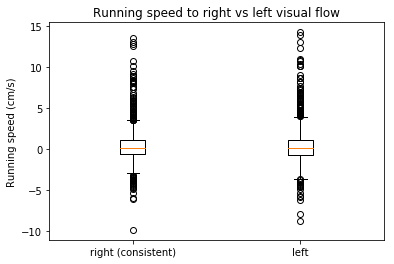

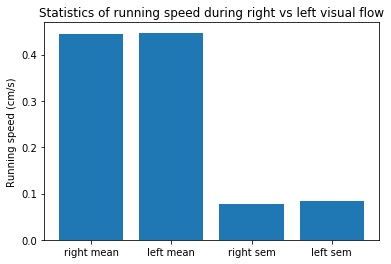

In [154]:
# Average and std of running when bricks fit with flow vs reverse (no surprise segs)
fig8, ax8 = plt.subplots()
ax8.boxplot([exp.run_array[exp.bricks.right_frame_n], exp.run_array[exp.bricks.left_frame_n]])
ax8.set_title('Running speed to right vs left visual flow')
ax8.set_ylabel('Running speed (cm/s)')
ax8.set_xticklabels(['right (consistent)', 'left'])

# bar plots of statistics
fig9, ax9 = plt.subplots()
ax9.bar(['right mean', 'left mean', 'right sem', 'left sem'], [np.mean(exp.run_array[exp.bricks.right_frame_n]), np.mean(exp.run_array[exp.bricks.left_frame_n]),
            scipy.stats.sem(exp.run_array[exp.bricks.right_frame_n]), scipy.stats.sem(exp.run_array[exp.bricks.left_frame_n])])
ax9.set_title('Statistics of running speed during right vs left visual flow')
ax9.set_ylabel('Running speed (cm/s)')

Text(17.2,0.5,'Running speed (cm/s)')

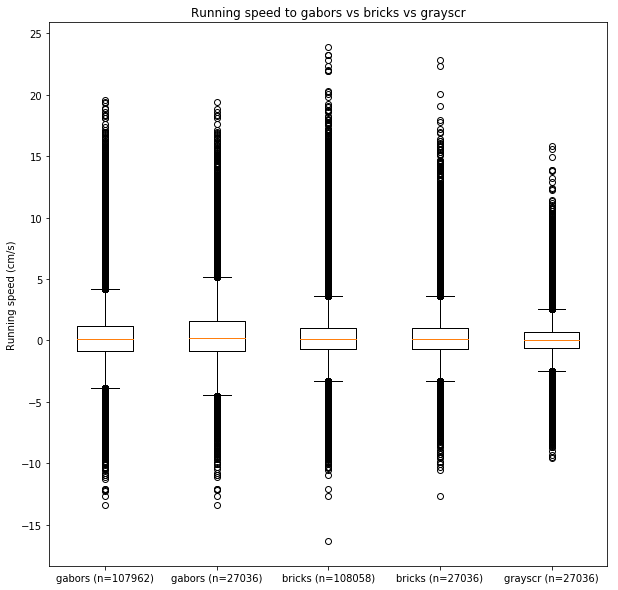

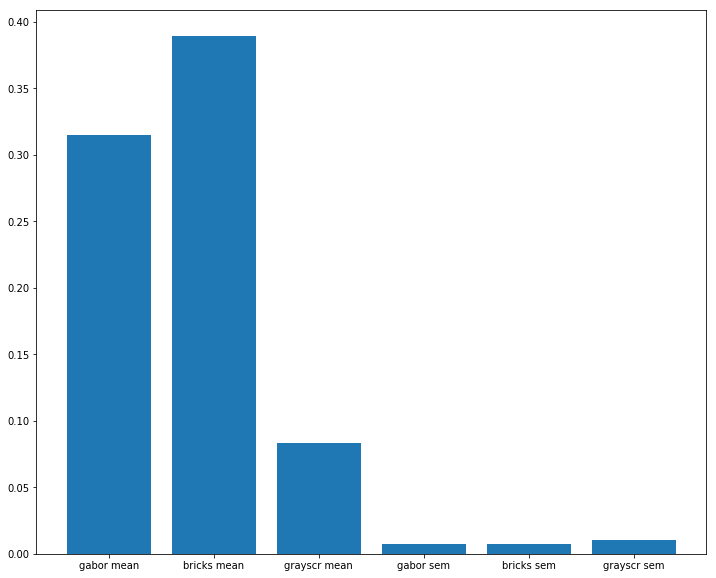

In [176]:
# Average and std running to gray (>1s) vs gabors vs bricks (incl surprise segs)
gab_run = []
[gab_run.extend(x) for x in exp.gabors.run]
bri_run = []
[bri_run.extend(x) for x in exp.bricks.run]
grayscr_run = []
[grayscr_run.extend(x) for x in exp.grayscr.run_excl]

gab_run_n = len(gab_run)
bri_run_n = len(bri_run)
grayscr_run_n = len(grayscr_run)

# shuffle
gab_run_rand = gab_run[:]
bri_run_rand = bri_run[:]
np.random.shuffle(gab_run_rand)
np.random.shuffle(bri_run_rand)

fig10, ax10 = plt.subplots(figsize=(10, 10))
ax10.boxplot([gab_run, gab_run[:grayscr_run_n], bri_run, bri_run_rand[:grayscr_run_n], 
              grayscr_run])
ax10.set_title('Running speed to gabors vs bricks vs grayscr')
ax10.set_ylabel('Running speed (cm/s)')
ax10.set_xticklabels(['gabors (n={})'.format(gab_run_n), 'gabors (n={})'.format(grayscr_run_n), 
                     'bricks (n={})'.format(bri_run_n), 'bricks (n={})'.format(grayscr_run_n),
                     'grayscr (n={})'.format(grayscr_run_n)])

# bar plots of statistics
fig11, ax11 = plt.subplots(figsize=(12, 10))
ax11.bar(['gabor mean', 'bricks mean', 'grayscr mean', 'gabor sem', 'bricks sem', 'grayscr sem'], 
         [np.mean(gab_run), np.mean(bri_run), np.mean(grayscr_run), 
          scipy.stats.sem(gab_run), scipy.stats.sem(bri_run), scipy.stats.sem(grayscr_run)])
ax9.set_title('Statistics of running speed during right vs left visual flow')
ax9.set_ylabel('Running speed (cm/s)')

